# Dividiendo Dataset

In [0]:
import pandas as pd
import numpy as np

In [0]:
classes = ["jonathan", "harry", "stefanie", "alejandro"]
num_classes = len(classes)
img_size = 100 # Fotos de 100x100 pixeles
num_channels = 1 # Fotos en escala de grises

In [0]:
jonathan_csv  = pd.read_csv("jonathan.csv",  header=None)
harry_csv     = pd.read_csv("harry.csv",     header=None)
stefanie_csv  = pd.read_csv("stefanie.csv",  header=None)
alejandro_csv = pd.read_csv("alejandro.csv", header=None)

In [0]:
np_jonathan  = np.array(jonathan_csv)
np_harry     = np.array(harry_csv)
np_stefanie  = np.array(stefanie_csv)
np_alejandro = np.array(alejandro_csv)

In [0]:
np.random.shuffle(np_jonathan)
np.random.shuffle(np_harry)
np.random.shuffle(np_stefanie)
np.random.shuffle(np_alejandro)

# 75% para entrenamiento, 25% para prueba
jonathan_train,  jonathan_test  = np.split(np_jonathan,  [75])
harry_train,     harry_test     = np.split(np_harry,     [75])
stefanie_train,  stefanie_test  = np.split(np_stefanie,  [75])
alejandro_train, alejandro_test = np.split(np_alejandro, [75])

In [0]:
# 300 fotos para entrenamiento
dataset_train = np.concatenate((jonathan_train,
                                harry_train,
                                stefanie_train,
                                alejandro_train),
                               axis=0)

# 100 fotos para prueba
dataset_test  = np.concatenate((jonathan_test,
                                harry_test,
                                stefanie_test,
                                alejandro_test),
                               axis=0)

In [0]:
train_photos = dataset_train[:,1:]
train_labels = dataset_train[:,0]

test_photos  = dataset_test[:,1:]
test_labels  = dataset_test[:,0]

In [0]:
train_labels_one_hot = np.zeros((len(train_labels), num_classes))
train_labels_one_hot[np.arange(len(train_labels)), train_labels] = 1.0

test_labels_one_hot = np.zeros((len(test_labels), num_classes))
test_labels_one_hot[np.arange(len(test_labels)), test_labels] = 1.0

#CNN

In [0]:
import tensorflow as tf

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

## Funcion para Crear una Capa Convolucional 

In [0]:
def create_weights(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [0]:
def create_biases(size):
  return tf.Variable(tf.constant(0.05, shape=[size]))

In [0]:
def create_convolutional_layer(input,
                               num_input_channels,
                               conv_filter_size,
                               num_filters):
    
  weights = create_weights(shape=[conv_filter_size,
                                  conv_filter_size,
                                  num_input_channels,
                                  num_filters])

  biases = create_biases(num_filters)

  layer = tf.nn.conv2d(input=input,
                       filter=weights,
                       strides=[1, 1, 1, 1],
                       padding='SAME')

  layer += biases

  layer = tf.nn.max_pool(value=layer,
                         ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1],
                         padding='SAME')

  layer = tf.nn.relu(layer)

  return layer

## Funcion para Crear una Capa Plana

In [0]:
def create_flatten_layer(layer):
  layer_shape = layer.get_shape()
  num_features = layer_shape[1:4].num_elements()
  layer = tf.reshape(layer, [-1, num_features])

  return layer

## Funcion para Crear una Capa Completamente Conectada

In [0]:
def create_fc_layer(input,
                    num_inputs,
                    num_outputs,
                    use_relu=True):
    
  weights = create_weights(shape=[num_inputs, num_outputs])
  biases = create_biases(num_outputs)

  layer = tf.matmul(input, weights) + biases

  if use_relu:
      layer = tf.nn.relu(layer)

  return layer

## Diseño

In [0]:
reset_graph()
session = tf.Session()

### Placeholders

In [16]:
x = tf.placeholder(tf.float32, shape=[None, img_size*img_size], name = "x")
x_reshaped = tf.reshape(x, shape=[-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Capas Convolucionales

In [0]:
filter_size_conv1 = 3
num_filters_conv1 = 32

layer_conv1 = create_convolutional_layer(input=x_reshaped,
                                         num_input_channels=num_channels,
                                         conv_filter_size=filter_size_conv1,
                                         num_filters=num_filters_conv1)

In [0]:
filter_size_conv2 = 3
num_filters_conv2 = 32

layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels=num_filters_conv1,
                                         conv_filter_size=filter_size_conv2,
                                         num_filters=num_filters_conv2)

In [0]:
filter_size_conv3 = 3
num_filters_conv3 = 64

layer_conv3 = create_convolutional_layer(input=layer_conv2,
                                         num_input_channels=num_filters_conv2,
                                         conv_filter_size=filter_size_conv3,
                                         num_filters=num_filters_conv3)

### Capa Plana

In [0]:
layer_flat = create_flatten_layer(layer_conv3)

### Capas Completamente Conectadas

In [0]:
fc_layer_size = 128

layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=fc_layer_size,
                            use_relu=True)

In [0]:
layer_fc2 = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size,
                            num_outputs=num_classes,
                            use_relu=False)

y_pred = tf.nn.softmax(layer_fc2, name="y_pred")
y_pred_cls = tf.argmax(y_pred, dimension=1)

session.run(tf.global_variables_initializer())

## Optimizacion

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                           labels=y_true)

cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session.run(tf.global_variables_initializer())

## Entrenamiento

In [24]:
n_epochs = 20

for epoch in range(n_epochs):
  session.run(optimizer, feed_dict={x: train_photos,
                                    y_true: train_labels_one_hot})
  
  acc_train = accuracy.eval(feed_dict={x: train_photos,
                                       y_true: train_labels_one_hot},
                            session=session)
  
  acc_test  = accuracy.eval(feed_dict={x: test_photos,
                                       y_true: test_labels_one_hot},
                            session=session)
  
  print("Epoch:", epoch+1, "Train accuracy:", acc_train, 
                           "Test accuracy :", acc_test)
  

Epoch: 1 Train accuracy: 0.34 Test accuracy : 0.39
Epoch: 2 Train accuracy: 0.27666667 Test accuracy : 0.27
Epoch: 3 Train accuracy: 0.39 Test accuracy : 0.41
Epoch: 4 Train accuracy: 0.35 Test accuracy : 0.45
Epoch: 5 Train accuracy: 0.58666664 Test accuracy : 0.59
Epoch: 6 Train accuracy: 0.7133333 Test accuracy : 0.73
Epoch: 7 Train accuracy: 0.77666664 Test accuracy : 0.82
Epoch: 8 Train accuracy: 0.75 Test accuracy : 0.74
Epoch: 9 Train accuracy: 0.75 Test accuracy : 0.75
Epoch: 10 Train accuracy: 0.75333333 Test accuracy : 0.75
Epoch: 11 Train accuracy: 0.8066667 Test accuracy : 0.8
Epoch: 12 Train accuracy: 0.87333333 Test accuracy : 0.92
Epoch: 13 Train accuracy: 0.9433333 Test accuracy : 0.96
Epoch: 14 Train accuracy: 0.94 Test accuracy : 0.91
Epoch: 15 Train accuracy: 0.9166667 Test accuracy : 0.91
Epoch: 16 Train accuracy: 0.9 Test accuracy : 0.89
Epoch: 17 Train accuracy: 0.9166667 Test accuracy : 0.9
Epoch: 18 Train accuracy: 0.9433333 Test accuracy : 0.94
Epoch: 19 Train 

# Prueba

In [0]:
def print_label(result):
  labels = [ "Jonathan", "Harry", "Stefanie", "Alejandro" ]
  
  max_index = 0
  max_value = result[0][0]
  
  for i in range(1, len(result[0])):
    if result[0][i] >= max_value:
      max_index = i
  
  print(labels[max_index])

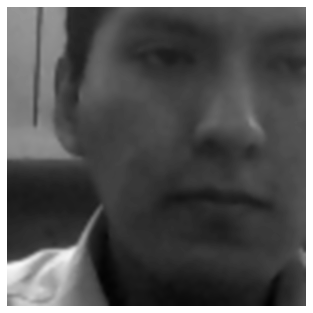

Jonathan


In [32]:
from matplotlib import pyplot as plt

index_photo = 0
photo = test_photos[index_photo].reshape(100,100)

plt.imshow(photo, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

photo = np.zeros((1, img_size*img_size))
photo[0] = test_photos[index_photo]

y_test_photo = np.zeros((1, 4))

feed_dict_testing = {x: photo, y_true: y_test_photo}
result = session.run(y_pred, feed_dict=feed_dict_testing)

print_label(result)